# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [ ]:
import onnx
from onnx_tf.backend import prepare
 
onnx_model = onnx.load("/home/tarao/models/research/tmp2/20210630.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("output/model.pb")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [1]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
from tensorflow.lite.python.util import run_graph_optimizations, get_grappler_config
import numpy as np
def frozen_keras_graph(func_model):
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(func_model)

    input_tensors = [
        tensor for tensor in frozen_func.inputs
        if tensor.dtype != tf.resource
    ]
    output_tensors = frozen_func.outputs
    graph_def = run_graph_optimizations(
        graph_def,
        input_tensors,
        output_tensors,
        config=get_grappler_config(["constfold", "function"]),
        graph=frozen_func.graph)

    return graph_def

def convert_saved_model_to_pb():
    model_dir = '/home/tarao/models/research/tmp2/20210630'
    model = tf.saved_model.load(model_dir)
    func_model = model.signatures["serving_default"]
    graph_def = frozen_keras_graph(func_model)
    tf.io.write_graph(graph_def, '.', 'frozen_graph_new_tf2.pb')

In [2]:
convert_saved_model_to_pb()

In [3]:
import tensorflow as tf
DEFAULT_FUNCTION_KEY = "serving_default"
saved_model_path = "/home/tarao/models/research/tmp2/20210630"
loaded = tf.saved_model.load(saved_model_path)
detect_fn = loaded.signatures[DEFAULT_FUNCTION_KEY]

OSError: SavedModel file does not exist at: /home/tarao/models/research/object_detection/colab_tutorials/frozen_graph_new_tf2.pb/{saved_model.pbtxt|saved_model.pb}

In [2]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

IMAGE_PATHS = ['/home/tarao/models/research/object_detection/test_images/image1.jpg']
PATH_TO_LABELS = os.path.join('/home/tarao/models/research', 'label2.pbtxt')
NUM_CLASSES = 90
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

for image_path in IMAGE_PATHS:
    print('Running inference for {}... '.format(image_path), end='')
    image_np = load_image_into_numpy_array(image_path)
    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()
    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('output_0'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['output_0'] = num_detections
    # detection_classes should be ints.
    detections['output_3'] = detections['output_3'].astype(np.int64)
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['output_1'],
        detections['output_3'],
        detections['output_2'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False)
    plt.figure(figsize=(10,10), dpi=200)
    plt.imshow(image_np_with_detections)
    print('Done')

plt.show()

Running inference for /home/tarao/models/research/object_detection/test_images/image1.jpg... 

NameError: name 'detect_fn' is not defined

In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image


# ## Env setup

# In[2]:


# This is needed to display the images.
# get_ipython().magic(u'matplotlib inline')
import matplotlib

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")


# ## Object detection imports
# Here are the imports from the object detection module.

# In[3]:


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


# # Model preparation 

# ## Variables
# 
# Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
# 
# By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

# In[4]:


# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/home/tarao/models/research/tmp2/new2.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/tarao/models/research', 'label2.pbtxt')

NUM_CLASSES = 90


# ## Download Model

# In[5]:
#print( " Downloading model ")
'''
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
'''
print (" Loading frozen model into memory")
# ## Load a (frozen) Tensorflow model into memory.

# In[6]:


detection_graph = tf.Graph()

with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


# ## Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

# In[7]:


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# ## Helper code

# In[8]:


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# # Detection

# In[9]:


# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/tarao/models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


# In[11]:




 Loading frozen model into memory


ValueError: Input 553 of node StatefulPartitionedCall was passed int64 from nonmaxsuppression_result_nonmaxsuppression__2334:0 incompatible with expected resource.

Make sure you have `pycocotools` installed

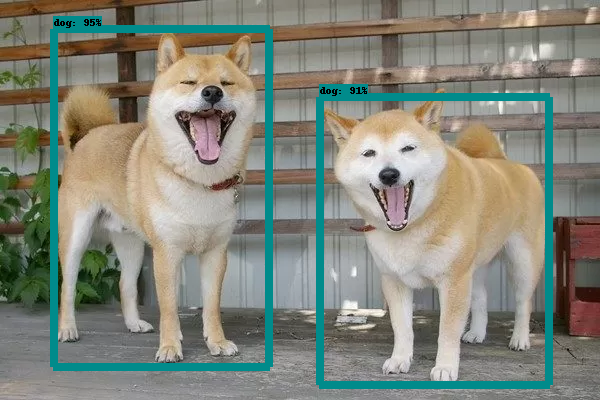

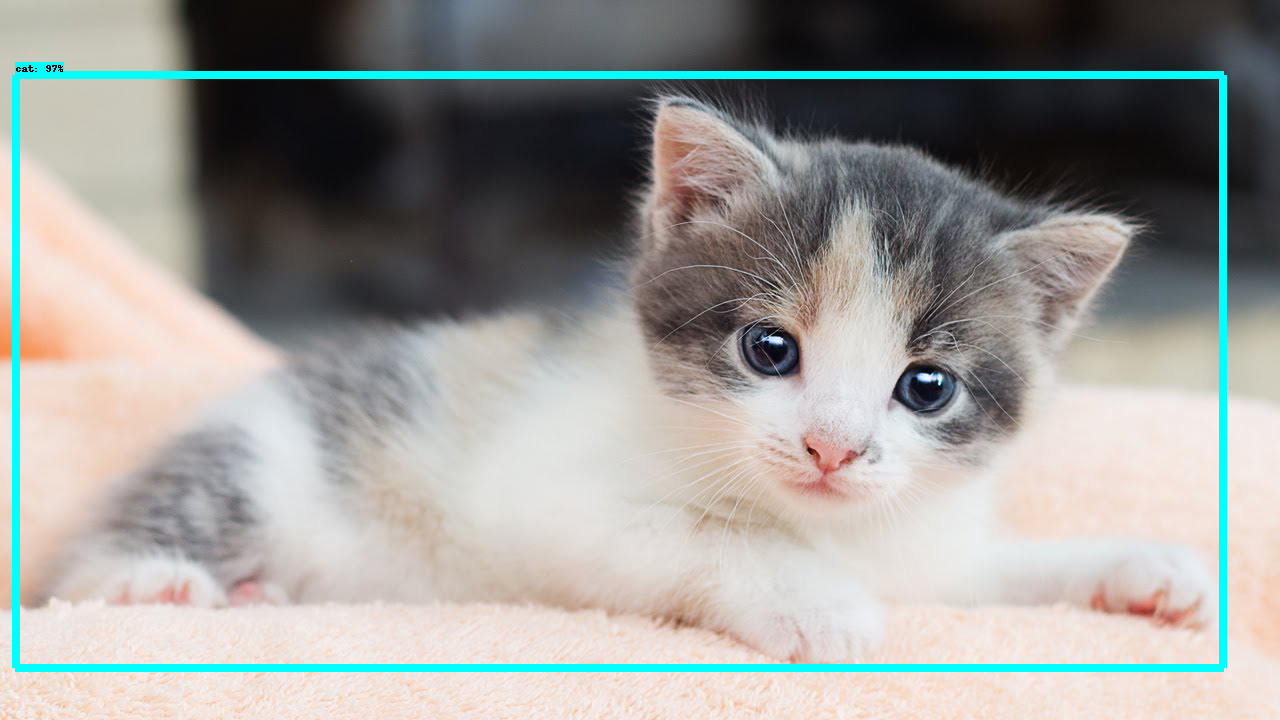

In [6]:
with detection_graph.as_default():
  with tf.compat.v1.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      display(Image.fromarray(image_np))
      i=0
      # plt.imsave(str(i)+'image',image_np )
# In[ ]:

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [7]:
import onnx_tf.backend
import onnx

import numpy as np
from PIL import Image

img_path = "/home/tarao/models/research/object_detection/test_images/image1.jpg"
model_path = "/home/tarao/models/research/tmp2/xxx.onnx"

onnx_model = onnx.load(model_path)
onnx.checker.check_model(onnx_model)
    


Compile protobufs and install the object_detection package

In [8]:
def main():
    # 画像の読み込みと加工
    img = Image.open(img_path)
    img = img.resize((224, 224))
    arr = np.asarray(img, dtype=np.float32)[np.newaxis, :, :, :]
    arr = arr.transpose(0, 3, 1, 2)
    
    # TensorFlowでONNX形式のモデルを実行
    tf_model = onnx_tf.backend.prepare(onnx_model, device='CPU')
    result = tf_model.run(arr)

    # 確率が高い順にクラスIDを昇順で出力
    prob = np.argsort(result.prob_1[0])[::-1]
    print("===== [Prob] =====")
    print(prob)

    # 確率が上位5個のクラスIDとその確率を表示する
    print("===== [TOP 5] =====")
    for i in range(5):
        print("{}: {}%".format(prob[i], result.prob_1[0][prob[i]] * 100))


if __name__ == "__main__":
    main()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


ValueError: in user code:

    /home/tarao/models/research/tmp/lib/python3.8/site-packages/onnx_tf/backend_tf_module.py:98 __call__  *
        output_ops = self.backend._onnx_node_to_tensorflow_op(onnx_node,
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/onnx_tf/backend.py:328 _onnx_node_to_tensorflow_op  *
        return handler.handle(node, tensor_dict=tensor_dict, strict=strict)
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/onnx_tf/handlers/handler.py:59 handle  *
        return ver_handle(node, **kwargs)
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/onnx_tf/handlers/backend/conv.py:15 version_11  *
        return cls.conv(node, kwargs["tensor_dict"])
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/onnx_tf/handlers/backend/conv_mixin.py:281 conv  *
        convolved = [
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1012 convolution_v2
        return convolution_internal(
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1142 convolution_internal
        return op(
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:2596 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py:969 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3557 _create_op_internal
        ret = Operation(
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/tarao/models/research/tmp/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Depth of input (224) is not a multiple of input depth of filter (3) for '{{node convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true](transpose_1, split)' with input shapes: [?,301,301,224], [3,3,3,32].


In [4]:
import onnxruntime as rt

import numpy as np
from PIL import Image, ImageDraw, ImageColor
import math
import matplotlib.pyplot as plt

# open and display image file
img = Image.open("/home/tarao/models/research/object_detection/test_images/image1.jpg")
plt.axis('off')
plt.imshow(img)
plt.show()

# reshape the flat array returned by img.getdata() to HWC and than add an additial
#dimension to make NHWC, aka a batch of images with 1 image in it
img_data = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
img_data = np.expand_dims(img_data.astype(np.uint8), axis=0)

# produce outputs in this order
outputs = ["num_detections:0", "detection_boxes:0", "detection_scores:0", "detection_classes:0"]

# load model and run inference
sess = rt.InferenceSession("/home/tarao/models/research/tmp2/xxx.onnx")
result = sess.run(outputs, {"image_tensor:0": img_data})
num_detections, detection_boxes, detection_scores, detection_classes = result

# print number of detections
print(num_detections)
print(detection_classes)

# draw boundary boxes and label for each detection
def draw_detection(draw, d, c):
    width, height = draw.im.size
    # the box is relative to the image size so we multiply with height and width to get pixels
    top = d[0] * height
    left = d[1] * width
    bottom = d[2] * height
    right = d[3] * width
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(height, np.floor(bottom + 0.5).astype('int32'))
    right = min(width, np.floor(right + 0.5).astype('int32'))
    label = "tmp"
#coco_classes[c]""
    label_size = draw.textsize(label)
    if top - label_size[1] >= 0:
        text_origin = tuple(np.array([left, top - label_size[1]]))
    else:
        text_origin = tuple(np.array([left, top + 1]))
    color = ImageColor.getrgb("red")
    thickness = 0
    draw.rectangle([left + thickness, top + thickness, right - thickness, bottom - thickness],outline=color)
    draw.text(text_origin, label, fill=color)

# loop over the results - each returned tensor is a batch
batch_size = num_detections.shape[0]
draw = ImageDraw.Draw(img)
for batch in range(0, batch_size):
    for detection in range(0, int(num_detections[batch])):
        c = detection_classes[batch][detection]
        d = detection_boxes[batch][detection]
        draw_detection(draw, d, c)

# show image file with object detection boundary boxes and labels
plt.figure(figsize=(80, 40))
plt.axis('off')
plt.imshow(img)
plt.savefig('figure04.jpg')

<ipython-input-4-d5683bbd32e3>:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


[2.]
[[18. 18.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


### Imports

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display


Import the object detection module.

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [ ]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [ ]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

# Detection

Load an object detection model:

In [ ]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [ ]:
print(detection_model.signatures['serving_default'].inputs)

And returns several outputs:

In [ ]:
detection_model.signatures['serving_default'].output_dtypes

In [ ]:
detection_model.signatures['serving_default'].output_shapes

Add a wrapper function to call the model, and cleanup the outputs:

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## Instance Segmentation

The instance segmentation model includes a `detection_masks` output: